# Анализ временных рядов с использованием Python
статья (https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

## Загрузим исходные данные из файла

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [252]:
data = pd.read_excel("data_oil.xlsx", 0, index_col='Date')
data.dropna(inplace=True)
print(data.head())
print('\n Data Types:')
print(data.dtypes)

              Oil  Nominal
Date                      
1946-01-01  15.24     1.17
1946-02-01  15.33     1.17
1946-03-01  15.16     1.17
1946-04-01  16.37     1.27
1946-05-01  16.28     1.27

 Data Types:
Oil        float64
Nominal    float64
dtype: object


Для анализа возьмем стоимость нефти номенированную по текущему курсу доллара (первая колонка файла), округли и отфильтруем данные начиная с 1980г.

In [253]:
ts = data[data.columns[0]]['1980-01-01':].astype(np.int64)
ts.head(10)

Date
1980-01-01     99
1980-02-01    111
1980-03-01    112
1980-04-01    115
1980-05-01    114
1980-06-01    113
1980-07-01    113
1980-08-01    108
1980-09-01    101
1980-10-01    100
Name: Oil, dtype: int64

# Проверка на стационарность

## Выведем  график исходных данных

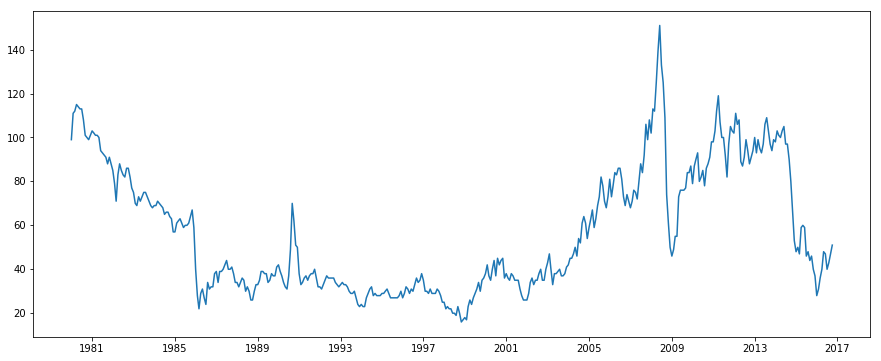

In [254]:
plt.plot(ts)

### Функция для тестирования стационарности

Тест Дики-Фуллера (http://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера)

In [255]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #if dfoutput[0] > dfoutput[4]['5%']:
    #    print('Time series is''nt stationar')
    #else:
    #    print('Time series is stationar')

In [256]:
print(dfoutput[4])

NameError: name 'dfoutput' is not defined

In [ ]:
test_stationarity(ts)

# Конвертация данных в стационарные

Попытамся обработать данные так, чтобы они сформированили устойчевые, стационарные структуры


## Выравнивание данных


In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

## Сглаживание:

### Скользящая средняя

In [ ]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

проверим на стационарность

In [ ]:
test_stationarity(ts_log)

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

уберем пустые значения (NaN)

In [ ]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

In [ ]:
test_stationarity(ts_log_moving_avg_diff)

результат хуже чем для ts_log

### Exponentially Weighted Moving Average

In [ ]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

In [ ]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

Тестовое значение меньше чем 1%, т.е. это наилучший результат из полученных

## Удаление тренда и сезонности

### Дифференциация:

In [ ]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Декомпозиция:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [ ]:
ts_log_decompose.head()

# Подбор модели для предсказания

### ARIMA модель:

Подберем параметры p,q,d модели

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=25, ax=ax2)

In [ ]:
def ARIMA_model(timesries, timesries_diff, p, d, q):
    model = ARIMA(timesries, order=(p, d, q))  
    results_ = model.fit(disp=-1)  
    plt.plot(timesries_diff)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-timesries_diff)**2))
    return results_

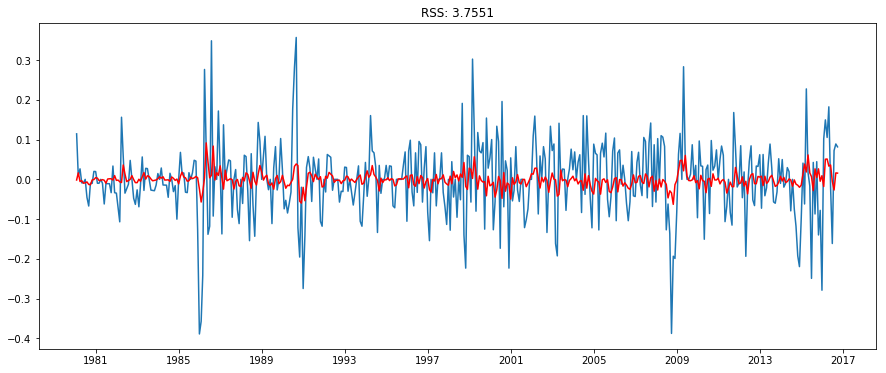

In [250]:
results_ARIMA = ARIMA_model(ts_log,ts_log_diff,p=1,d=1,q=1)

### Сравнение предсказания и исходных данных:

In [180]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1980-02-01   -0.001620
1980-03-01    0.016405
1980-04-01   -0.005385
1980-05-01   -0.003399
1980-06-01   -0.009606
dtype: float64


In [181]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
1980-02-01   -0.001620
1980-03-01    0.014785
1980-04-01    0.009400
1980-05-01    0.006001
1980-06-01   -0.003604
dtype: float64


In [182]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
1980-01-01    4.595120
1980-02-01    4.593499
1980-03-01    4.609905
1980-04-01    4.604520
1980-05-01    4.601121
dtype: float64

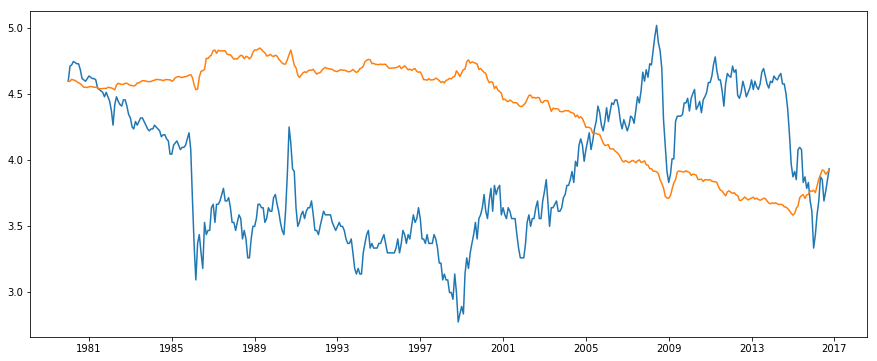

In [183]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

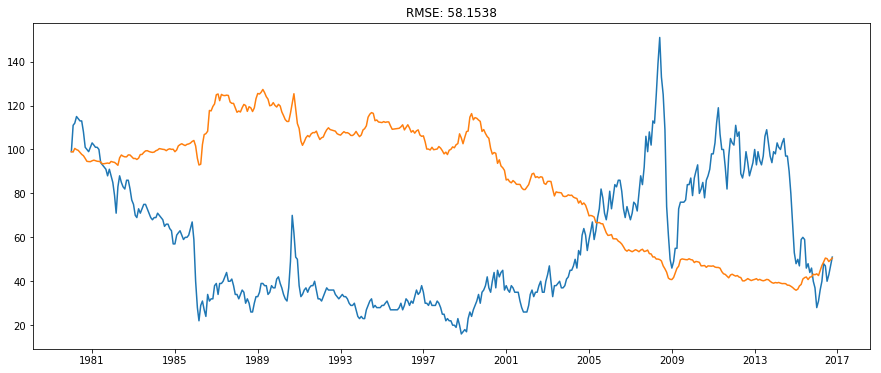

In [184]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Анализ не дал высокой точности предсказания. Возможно, что модель просто не может обеспечить на тех данных которые доступны нормальное предсказание и нужны дополнительные параметры, которые уточнят модель.